# Part A is copied here and minimized

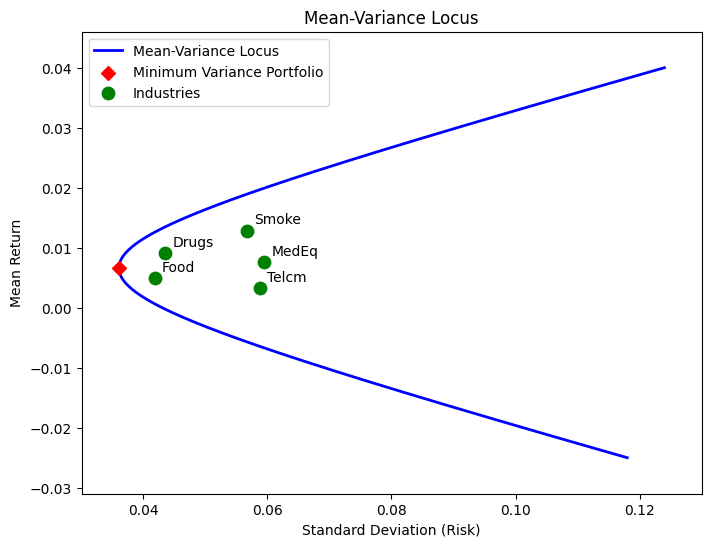

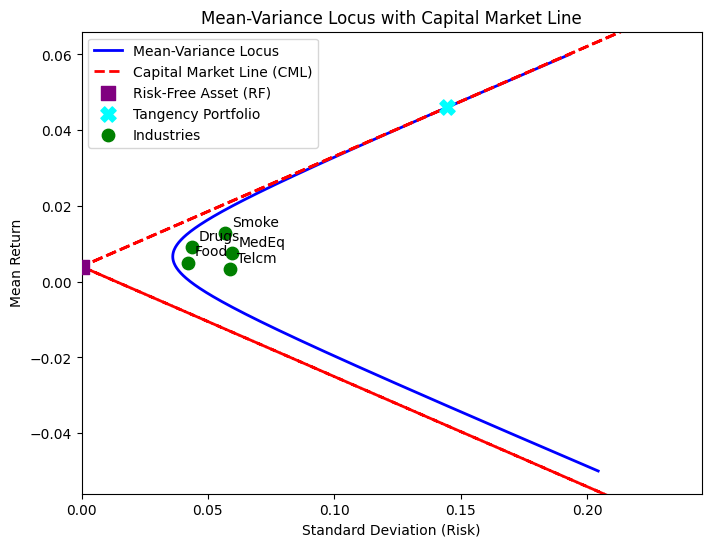


Tangency Portfolio Characteristics for Specified Graph:
    Characteristic    Value
   Expected Return 0.046030
          Variance 0.020911
Standard Deviation 0.144607

Tangency Portfolio Weights for Specified Graph:
         Weight
Food  -3.000123
Smoke  3.366369
MedEq  0.552711
Drugs  2.265163
Telcm -2.184119


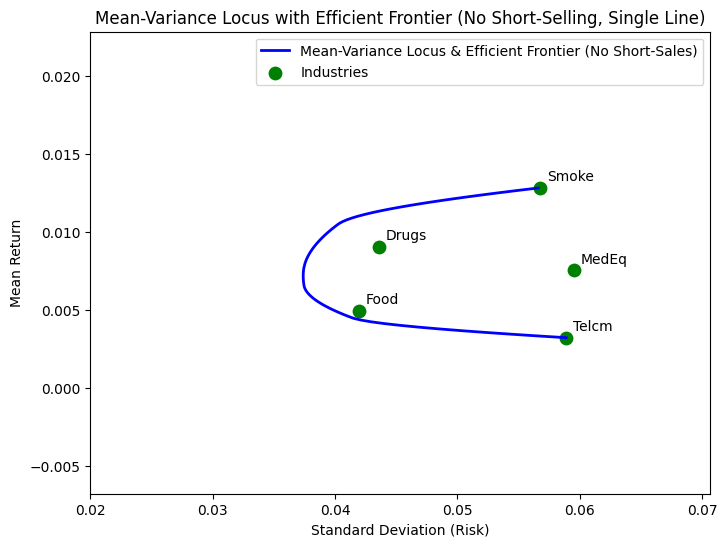

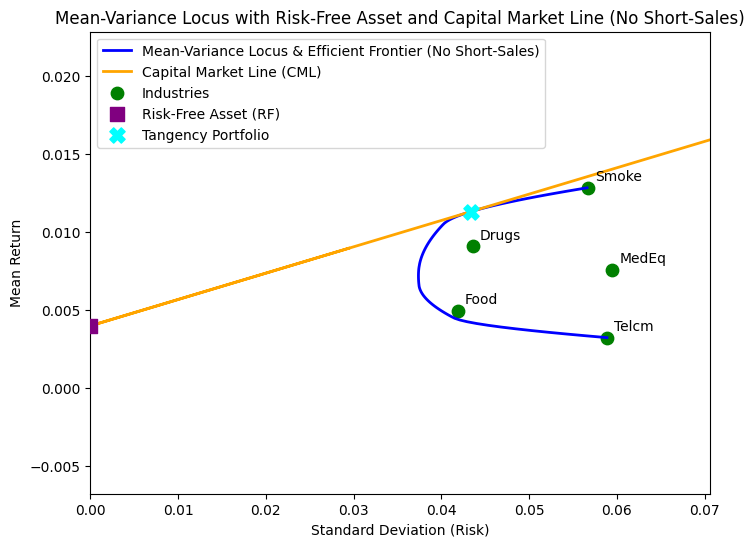


Tangency Portfolio Characteristics:
    Characteristic    Value
   Expected Return 0.011321
          Variance 0.001882
Standard Deviation 0.043377

Tangency Portfolio Weights:
         Weight
Food   0.000000
Smoke  0.592492
MedEq  0.000000
Drugs  0.407508
Telcm  0.000000


In [2]:
# %% [markdown]
# # Prepare Data

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Load new dataset
file_path = "Returns_Data_Cleaned.csv"  # Updated file path
df = pd.read_csv(file_path)

# Rename the first column (date column) properly
df.rename(columns={'Unnamed: 0': 'Dates'}, inplace=True)

# Strip spaces from column names
df.columns = df.columns.str.strip()

# Filter for only the required industries
selected_industries = ["Food", "Smoke", "MedEq", "Drugs", "Telcm"]
df = df[["Dates"] + selected_industries]

# Convert Date column to DateTime format
df = df[df["Dates"].astype(str).str.match(r"^\d{6}$")]  # Keep only YYYYMM format
df["Dates"] = pd.to_datetime(df["Dates"], format="%Y%m")

# Filter data for the required date range
df_filtered = df[(df["Dates"] >= "2019-12-01") & (df["Dates"] <= "2024-11-01")]

# Convert returns from percentage format to decimal (divide by 100)
df_filtered.iloc[:, 1:] = df_filtered.iloc[:, 1:].div(100)

# Set Date as index
df_filtered.set_index("Dates", inplace=True)


# %% [markdown]
# # Part A

# %% [markdown]
# ## 1

# %%
# Step 1: Calculate the mean return for each column (Monthly Average Returns)
mean_returns = df_filtered.mean(axis=0)

# Recalculate monthly variance from the original dataset
monthly_variance = df_filtered.var(axis=0, ddof=1)

# Compute the standard deviation
monthly_std_dev = monthly_variance**0.5

# Step 2: Extract the sample covariance matrix (Σ) and the mean returns vector (μ)
cov_matrix = df_filtered.cov(ddof=1).values  # Covariance matrix Σ (sample statistics)
mean_returns_vector = mean_returns.values    # Vector of expected returns (μ)
ones_vector = np.ones(mean_returns_vector.shape)  # Vector of ones

# Step 3: Calculate A, B, C, and Δ (Delta) using sample statistics
inv_cov_matrix = np.linalg.inv(cov_matrix)     # Σ^-1 (inverse of covariance matrix)
A = ones_vector @ inv_cov_matrix @ ones_vector  # A = 1'Σ^-11
B = ones_vector @ inv_cov_matrix @ mean_returns_vector  # B = 1'Σ^-1μ
C = mean_returns_vector @ inv_cov_matrix @ mean_returns_vector  # C = μ'Σ^-1μ
Delta = (A * C) - (B ** 2)  # Δ = AC - B^2

# Step 4: Compute the Minimum Variance Portfolio (MVP)
mvp_weights = (inv_cov_matrix @ ones_vector) / A
mvp_return = np.dot(mvp_weights, mean_returns_vector)
mvp_std = np.sqrt(mvp_weights.T @ cov_matrix @ mvp_weights)  # Standard deviation of MVP

# Step 5: Define a range of portfolio returns (μ)
target_returns = np.linspace(-0.025, 0.04, 500)  # Independent range for μ (Y-axis values)

# Step 6: Compute λ and γ for the given μ values
lambda_values = (C - target_returns * B) / Delta
gamma_values = (target_returns * A - B) / Delta

# Step 7: Compute the portfolio variances (σ^2)
sigma_squared = []
for lam, gam in zip(lambda_values, gamma_values):
    # Compute weights: w = λ * Σ^-1 * 1 + γ * Σ^-1 * μ
    w = lam * (inv_cov_matrix @ ones_vector) + gam * (inv_cov_matrix @ mean_returns_vector)
    # Compute portfolio variance: σ^2 = w' Σ w
    sigma_squared.append(w.T @ cov_matrix @ w)

# Convert to NumPy array
sigma_squared = np.array(sigma_squared)
efficient_risks = np.sqrt(sigma_squared)  # Standard deviations (Risk)

# Identify the efficient part (upper part of the parabola)
efficient_idx = np.argmax(target_returns > mvp_return)  # Index where frontier becomes efficient
efficient_risks_upper = efficient_risks[efficient_idx:]
target_returns_upper = target_returns[efficient_idx:]

# Plot Mean-Variance Locus
plt.figure(figsize=(8, 6))

# Combined Mean-Variance Locus and Efficient Frontier (Single Formatted Line)
plt.plot(efficient_risks, target_returns, label="Mean-Variance Locus", color="blue", linewidth=2)

# Minimum Variance Portfolio (MVP)
plt.scatter(mvp_std, mvp_return, color="red", label="Minimum Variance Portfolio", zorder=3, marker="D", s=50)

# Industry points (Green Dots)
plt.scatter(monthly_std_dev, mean_returns, marker='o', color='green', label="Industries", s=80)

# Annotate each industry point
for industry, x, y in zip(df_filtered.columns, monthly_std_dev, mean_returns):
    plt.annotate(industry, (x, y), fontsize=10, xytext=(5, 5), textcoords="offset points")

# Labels and title
plt.xlabel("Standard Deviation (Risk)")
plt.ylabel("Mean Return")
plt.title("Mean-Variance Locus")

# Expand axis limits for better visualization
plt.xlim(min(efficient_risks) - 0.006, max(efficient_risks) + 0.006)  # Expanded X range
plt.ylim(min(target_returns) - 0.006, max(target_returns) + 0.006)  # Expanded Y range

plt.legend()
plt.grid(False)

# Show the plot
plt.show()


# %% [markdown]
# ## 2

# %%
# Define the risk-free rate (0.4% per month)
rf = 0.004  

# Compute the inverse of the covariance matrix
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Compute the excess returns (mean returns - risk-free rate)
excess_returns = mean_returns - rf

# Compute the tangency portfolio weights
tangency_weights = inv_cov_matrix @ excess_returns / (ones_vector @ inv_cov_matrix @ excess_returns)

# Compute the expected return and standard deviation of the tangency portfolio
tangency_return = np.dot(tangency_weights, mean_returns)
tangency_std = np.sqrt(tangency_weights.T @ cov_matrix @ tangency_weights)

# Define a range of portfolio returns for the Mean-Variance Locus
target_returns = np.linspace(-0.05, 0.06, 500)

# Compute λ and γ for the given μ values
lambda_values = (C - target_returns * B) / Delta
gamma_values = (target_returns * A - B) / Delta

# Compute the portfolio variances (σ^2)
sigma_squared = []
for lam, gam in zip(lambda_values, gamma_values):
    w = lam * (inv_cov_matrix @ ones_vector) + gam * (inv_cov_matrix @ mean_returns_vector)
    sigma_squared.append(w.T @ cov_matrix @ w)

# Convert to NumPy array
sigma_squared = np.array(sigma_squared)
efficient_risks = np.sqrt(sigma_squared)  # Standard deviations (Risk)

# Define the Capital Market Line (CML) symmetrically in both directions
cml_risks = np.linspace(-max(efficient_risks) * 1.5, max(efficient_risks) * 1.5, 300)
cml_risks = np.abs(cml_risks)  # Ensure standard deviation remains positive
cml_returns = rf + ((tangency_return - rf) / tangency_std) * np.concatenate((-cml_risks[::-1], cml_risks))

# Plot Mean-Variance Locus With Risk-Free Asset
plt.figure(figsize=(8, 6))

# Plot Mean-Variance Locus as a Single Line
plt.plot(efficient_risks, target_returns, label="Mean-Variance Locus", color='blue', linewidth=2)

# Plot the Capital Market Line (CML) extended symmetrically
plt.plot(np.concatenate((cml_risks[::-1], cml_risks)), cml_returns, label="Capital Market Line (CML)", linestyle="--", color="red", linewidth=2)

# Plot risk-free asset and tangency portfolio
plt.scatter(0, rf, color="purple", label="Risk-Free Asset (RF)", zorder=3, marker="s", s=100)
plt.scatter(tangency_std, tangency_return, color="cyan", label="Tangency Portfolio", zorder=3, marker="X", s=120)

# Industry points (Green Dots)
plt.scatter(monthly_std_dev, mean_returns, marker='o', color='green', label="Industries", s=80)

# Annotate each industry point
for industry, x, y in zip(df_filtered.columns, monthly_std_dev, mean_returns):
    plt.annotate(industry, (x, y), fontsize=10, xytext=(5, 5), textcoords="offset points")

# Labels and title
plt.xlabel("Standard Deviation (Risk)")
plt.ylabel("Mean Return")
plt.title("Mean-Variance Locus with Capital Market Line")

# Expand axis limits for better visualization
plt.xlim(0, max(efficient_risks) * 1.2)  # Ensure positive risk range
plt.ylim(min(target_returns) - 0.006, max(target_returns) + 0.006)  # Properly centered Y range

plt.legend()
plt.grid(False)

# Show the plot
plt.show()


# %% [markdown]
# ## 3

# %%
# Compute the Tangency Portfolio characteristics with 6 decimal places for the specified graph
tangency_expected_return = round(tangency_return, 6)  # Expected return of the Tangency Portfolio
tangency_variance = round(tangency_std ** 2, 6)  # Variance of the Tangency Portfolio
tangency_std_rounded = round(tangency_std, 6)  # Standard Deviation of the Tangency Portfolio

# Create a DataFrame for Tangency Portfolio characteristics
tangency_portfolio_info = pd.DataFrame({
    "Characteristic": ["Expected Return", "Variance", "Standard Deviation"],
    "Value": [tangency_expected_return, tangency_variance, tangency_std_rounded]
})

# Create a DataFrame for Tangency Portfolio Weights with 6 decimal places
tangency_weights_df = pd.DataFrame(tangency_weights, index=mean_returns.index, columns=["Weight"])
tangency_weights_df = tangency_weights_df.round(6)

# Display the Tangency Portfolio characteristics and weights
print("\nTangency Portfolio Characteristics for Specified Graph:")
print(tangency_portfolio_info.to_string(index=False))

print("\nTangency Portfolio Weights for Specified Graph:")
print(tangency_weights_df.to_string())

# %% [markdown]
# ## 4

# %%
# Ensure num_assets is defined
num_assets = len(mean_returns)

# Function to calculate portfolio volatility
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Compute the Minimum Variance Portfolio (MVP)
ones_vector = np.ones(num_assets)
inv_cov_matrix = np.linalg.inv(cov_matrix)
mvp_weights = (inv_cov_matrix @ ones_vector) / (ones_vector.T @ inv_cov_matrix @ ones_vector)
min_var_return = np.dot(mvp_weights, mean_returns)  # Define min_var_return
min_var_std = np.sqrt(mvp_weights.T @ cov_matrix @ mvp_weights)  # Compute min variance risk

# Modify the efficient frontier to include short-sale constraints (weights must be non-negative)
bounds = [(0, 1)] * num_assets  # No short-selling allowed

# Generate efficient frontier with short-sale constraints
target_returns_no_short = np.linspace(min(mean_returns) - 0, max(mean_returns) + 0.012857, 200)
efficient_risks_no_short = []

for target in target_returns_no_short:
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
                   {'type': 'eq', 'fun': lambda w: np.dot(w, mean_returns) - target})

    init_guess = np.ones(num_assets) / num_assets  # Ensure initial weights sum to 1

    result = minimize(portfolio_volatility, init_guess, args=(cov_matrix,), method='SLSQP',
                      constraints=constraints, bounds=bounds)

    efficient_risks_no_short.append(result.fun)

# Identify the efficient part (upper part of the parabola)
efficient_idx_no_short = np.argmax(target_returns_no_short > min_var_return)  # Index where frontier becomes efficient
efficient_risks_upper_no_short = efficient_risks_no_short[efficient_idx_no_short:]
target_returns_upper_no_short = target_returns_no_short[efficient_idx_no_short:]

# Define the cutoff points for the efficient frontier and mean-variance locus
max_return_limit = max(mean_returns["Smoke"], mean_returns["Telcm"])

# Filter the efficient frontier data to stop at the maximum return limit
valid_indices = target_returns_no_short <= max_return_limit
efficient_risks_no_short_limited = np.array(efficient_risks_no_short)[valid_indices]
target_returns_no_short_limited = np.array(target_returns_no_short)[valid_indices]

# Find the new efficient frontier part (upper portion)
efficient_idx_no_short_limited = np.argmax(target_returns_no_short_limited > min_var_return)
efficient_risks_upper_no_short_limited = efficient_risks_no_short_limited[efficient_idx_no_short_limited:]
target_returns_upper_no_short_limited = target_returns_no_short_limited[efficient_idx_no_short_limited:]

# Ensure standard deviations and mean returns have the same size
industry_std_no_short = df_filtered.std()[mean_returns.index]

# Plot the adjusted mean-variance locus with short-sale constraints as a single line
plt.figure(figsize=(8, 6))

# Combined Mean-Variance Locus and Efficient Frontier (Single Line)
plt.plot(efficient_risks_no_short_limited, target_returns_no_short_limited, 
         label="Mean-Variance Locus & Efficient Frontier (No Short-Sales)", color="blue", linewidth=2)

# Industry points (Green Dots)
plt.scatter(industry_std_no_short, mean_returns, marker='o', color='green', label="Industries", s=80)

# Annotate each industry point correctly
for industry, x, y in zip(mean_returns.index, industry_std_no_short, mean_returns):
    plt.annotate(industry, (x, y), fontsize=10, xytext=(5, 5), textcoords="offset points")

# Labels and title
plt.xlabel("Standard Deviation (Risk)")
plt.ylabel("Mean Return")
plt.title("Mean-Variance Locus with Efficient Frontier (No Short-Selling, Single Line)")

# Adjust axis limits to properly align the graph
plt.xlim(0.02, max(efficient_risks_no_short_limited) * 1.2)  # Ensuring standard deviation remains positive
plt.ylim(min(target_returns_no_short_limited) - 0.01, max_return_limit + 0.01)  # Properly centered Y range

plt.legend()
plt.grid(False)

# Show the corrected plot
plt.show()

# %% [markdown]
# ## 5

# %%
# Function to calculate portfolio volatility
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Adjust mean returns to be in excess return form (subtract risk-free rate)
mean_returns_excess = mean_returns - rf

# Generate efficient frontier with short-sale constraints in excess return form
target_returns_no_short_rf = np.linspace(min(mean_returns_excess), max(mean_returns_excess) + 0.012857, 200)
efficient_risks_no_short_rf = []

# Solve for each target return in excess return space
for target in target_returns_no_short_rf:
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
                   {'type': 'eq', 'fun': lambda w: np.dot(w, mean_returns_excess) - target}]

    result = minimize(lambda w: portfolio_volatility(w, cov_matrix), init_guess, method='SLSQP',
                      constraints=constraints, bounds=bounds)

    if result.success:
        efficient_risks_no_short_rf.append(result.fun)
    else:
        efficient_risks_no_short_rf.append(np.nan)  # Replace failed optimizations with NaN

# Convert lists to numpy arrays and filter out NaN values
efficient_risks_no_short_rf = np.array(efficient_risks_no_short_rf)
target_returns_no_short_rf = np.array(target_returns_no_short_rf)

valid_indices_rf = ~np.isnan(efficient_risks_no_short_rf)
efficient_risks_no_short_rf = efficient_risks_no_short_rf[valid_indices_rf]
target_returns_no_short_rf = target_returns_no_short_rf[valid_indices_rf]

# Define the cutoff points for the efficient frontier
max_return_limit_rf = max(mean_returns_excess["Smoke"], mean_returns_excess["Telcm"])

# Filter the efficient frontier data to stop at the maximum return limit
valid_indices_rf = target_returns_no_short_rf <= max_return_limit_rf
efficient_risks_no_short_limited_rf = efficient_risks_no_short_rf[valid_indices_rf]
target_returns_no_short_limited_rf = target_returns_no_short_rf[valid_indices_rf]

# Ensure standard deviations and mean returns have the same size
industry_std_no_short_rf = df_filtered.std()[mean_returns.index]

# Compute the Tangency Portfolio using the Sharpe Ratio maximization
def objective_sharpe(w, mean_returns, cov_matrix, rf):
    portfolio_return = np.dot(w, mean_returns)  # Portfolio expected return (absolute return)
    portfolio_volatility = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))  # Portfolio risk (volatility)
    sharpe_ratio = (portfolio_return - rf) / portfolio_volatility  # Sharpe ratio
    return -sharpe_ratio  # Maximize Sharpe Ratio by minimizing its negative

# Constraint: sum of weights = 1
constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]

# Optimize for the tangency portfolio weights
result_tangency = minimize(objective_sharpe, init_guess, args=(mean_returns, cov_matrix, rf), 
                           bounds=bounds, constraints=constraints)

# Extract optimal weights and compute tangency portfolio return and risk
if result_tangency.success:
    optimal_weights = result_tangency.x
    tangency_return = np.dot(optimal_weights, mean_returns)  # Tangency Portfolio return (absolute return)
    tangency_std = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))  # Tangency Portfolio risk

# Generate the extended Capital Market Line (CML)
cml_risk = np.linspace(-max(efficient_risks_no_short_limited_rf) * 0.5, max(efficient_risks_no_short_limited_rf) * 1.5, 300)  
cml_risk = np.abs(cml_risk)  # Ensure standard deviation remains positive
cml_return = rf + ((tangency_return - rf) / tangency_std) * cml_risk  # CML equation with correct RF intercept

# Plot Mean-Variance Locus with Risk-Free Asset (No Short-Sales) and Extended CML
plt.figure(figsize=(8, 6))

# Combined Mean-Variance Locus and Efficient Frontier (Single Line with RF Adjustment)
plt.plot(efficient_risks_no_short_limited_rf, target_returns_no_short_limited_rf + rf, 
         label="Mean-Variance Locus & Efficient Frontier (No Short-Sales)", color="blue", linewidth=2)

# Capital Market Line (CML) fully extended
plt.plot(cml_risk, cml_return, label="Capital Market Line (CML)", color="orange", linewidth=2)

# Industry points (Green Dots) in absolute return form
plt.scatter(industry_std_no_short_rf, mean_returns, marker='o', color='green', label="Industries", s=80)

# Annotate each industry point correctly
for industry, x, y in zip(mean_returns.index, industry_std_no_short_rf, mean_returns):
    plt.annotate(industry, (x, y), fontsize=10, xytext=(5,5), textcoords="offset points")

# Plot Risk-Free Asset at (0, RF) instead of (0,0)
plt.scatter(0, rf, color="purple", label="Risk-Free Asset (RF)", zorder=3, marker="s", s=100)

# Plot Tangency Portfolio at the optimal risk-return tradeoff
plt.scatter(tangency_std, tangency_return, color="cyan", label="Tangency Portfolio", zorder=3, marker="X", s=120)

# Labels and title
plt.xlabel("Standard Deviation (Risk)")
plt.ylabel("Mean Return")
plt.title("Mean-Variance Locus with Risk-Free Asset and Capital Market Line (No Short-Sales)")

# Adjust axis limits for proper visualization
plt.xlim(0, max(efficient_risks_no_short_limited_rf) * 1.2)  # Ensuring standard deviation remains positive
plt.ylim(min(target_returns_no_short_limited_rf) + rf - 0.01, max(target_returns_no_short_limited_rf) + rf + 0.01)  # Properly centered Y range

plt.legend()
plt.grid(False)

# Show the corrected plot
plt.show()


# %% [markdown]
# ## 6

# %%
# Compute the Tangency Portfolio characteristics with 6 decimal places
tangency_expected_return = round(tangency_return, 6)  # Expected return of the Tangency Portfolio
tangency_variance = round(tangency_std ** 2, 6)  # Variance of the Tangency Portfolio
tangency_std_rounded = round(tangency_std, 6)  # Standard Deviation of the Tangency Portfolio

# Create a DataFrame for Tangency Portfolio characteristics
tangency_portfolio_info = pd.DataFrame({
    "Characteristic": ["Expected Return", "Variance", "Standard Deviation"],
    "Value": [tangency_expected_return, tangency_variance, tangency_std_rounded]
})

# Create a DataFrame for Tangency Portfolio Weights with 6 decimal places
tangency_weights_df = pd.DataFrame(optimal_weights, index=mean_returns.index, columns=["Weight"])
tangency_weights_df = tangency_weights_df.round(6)

# Display the Tangency Portfolio characteristics and weights
print("\nTangency Portfolio Characteristics:")
print(tangency_portfolio_info.to_string(index=False))

print("\nTangency Portfolio Weights:")
print(tangency_weights_df.to_string())

# %% [markdown]
# # Part B

# %% [markdown]
# 




In [3]:
df_filtered

,Food,Smoke,MedEq,Drugs,Telcm
Dates,,,,,
2019-12-01,0.0306,0.0322,0.0124,0.0408,0.0104
2020-01-01,-0.0138,-0.0366,-0.0096,-0.0246,-0.0211
2020-02-01,-0.0930,-0.0671,-0.0765,-0.0477,-0.0621
2020-03-01,-0.0424,-0.0676,-0.1144,-0.0239,-0.1330
2020-04-01,0.0860,0.0198,0.1386,0.1324,0.0951
2020-05-01,0.0367,-0.0121,0.0524,0.0387,0.0481
2020-06-01,-0.0029,-0.0072,-0.0158,-0.0132,-0.0262
2020-07-01,0.0598,0.0778,0.1101,0.0140,0.0505
2020-08-01,0.0345,0.0477,0.0349,0.0205,0.0560


# Start Here

In [4]:
df_full_years = pd.read_csv("Selected_Industry_Data.csv",header=0)

df_filtered = df_full_years.copy()


columns_to_scale = df_filtered.columns.drop('DATE')
df_filtered[columns_to_scale] = df_filtered[columns_to_scale] / 100


print(df_filtered.head())

     DATE    Food   Smoke   Drugs   MedEq   Telcm
0  192607  0.0012  0.0129  0.0091  0.0495  0.0083
1  192608  0.0268  0.0650  0.0426  0.0420  0.0217
2  192609  0.0158  0.0126 -0.0026  0.0402  0.0241
3  192610 -0.0368  0.0106 -0.0176  0.0347 -0.0011
4  192611  0.0626  0.0455  0.0576  0.0433  0.0163


In [5]:
df_filtered

,DATE,Food,Smoke,Drugs,MedEq,Telcm
0,192607,0.0012,0.0129,0.0091,0.0495,0.0083
1,192608,0.0268,0.0650,0.0426,0.0420,0.0217
2,192609,0.0158,0.0126,-0.0026,0.0402,0.0241
3,192610,-0.0368,0.0106,-0.0176,0.0347,-0.0011
4,192611,0.0626,0.0455,0.0576,0.0433,0.0163
...,...,...,...,...,...,...
1177,202408,0.0509,0.0796,0.0628,0.0756,0.0121
1178,202409,0.0095,-0.0131,-0.0310,0.0083,0.0563
1179,202410,-0.0428,0.0846,-0.0327,-0.0111,0.0236
1180,202411,0.0063,0.0215,-0.0292,0.0580,0.0918


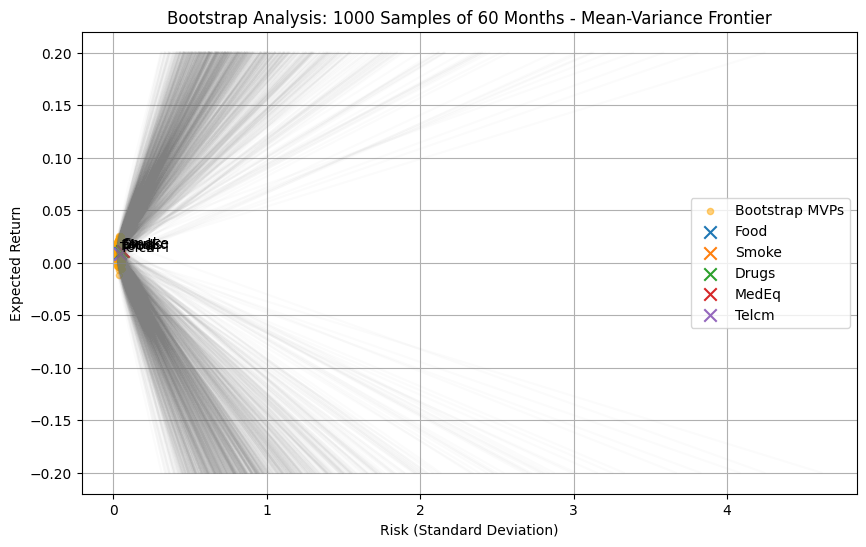

In [6]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



bootstrap_iterations = 1000       
sample_size = 60                 

# 用于存储每个 bootstrap 样本下最小方差组合 (MVP) 的预期收益和风险
mvp_returns_bootstrap = []
mvp_risks_bootstrap = []

# 建立图形窗口
plt.figure(figsize=(10, 6))

for i in range(bootstrap_iterations):
    # -------------------------------
    # 1. 从 df_filtered 中有放回抽取 60 个月数据（bootstrap sample）
    # -------------------------------
    sample = df_filtered.sample(n=sample_size, replace=True)
    # 去掉 DATE 列，仅保留收益数据
    returns = sample.drop(columns='DATE')
    
    # -------------------------------
    # 2. 计算各行业的样本均值和标准差
    # -------------------------------
    mean_returns = returns.mean()
    sd_returns = returns.std()
    
    # -------------------------------
    # 3. 计算收益的协方差矩阵
    # -------------------------------
    cov_matrix = returns.cov()
    
    # -------------------------------
    # 4. 计算均值—方差分析中的关键参数 A, B, C 和 Δ
    #     其中： A = 1' Σ⁻¹ 1, B = 1' Σ⁻¹ μ, C = μ' Σ⁻¹ μ, Δ = A * C - B²
    # -------------------------------
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    ones_vector = np.ones(len(mean_returns))
    A = ones_vector @ (inv_cov_matrix @ ones_vector)
    B = ones_vector @ (inv_cov_matrix @ mean_returns.values)
    C = mean_returns.values @ (inv_cov_matrix @ mean_returns.values)
    Delta = A * C - B**2

    # 检查 A>0, C>0 且 Δ>0 的条件
    if not (A > 0 and C > 0 and Delta > 0):
        continue  # 如果不满足，则跳过这个样本
    
    # -------------------------------
    # 5. 为构造有效前沿定义一系列目标预期收益 μ 的取值范围
    #    （注意：这里根据收益的数量级选择合适的范围，本例设定为 -10% 到 10%）
    # -------------------------------
    mu_values = np.linspace(-0.2, 0.2, 100)  # μ从 -0.1 到 0.1，100个点

    # 根据理论公式，计算 λ 和 γ（λ = (C - μB)/Δ, γ = (μA - B)/Δ）
    lambda_values = (C - mu_values * B) / Delta
    gamma_values = (mu_values * A - B) / Delta

    # -------------------------------
    # 6. 计算各目标收益率下的投资组合方差：σ² = (Aμ² - 2Bμ + C)/Δ
    # -------------------------------
    variance_values = (A * mu_values**2 - 2 * B * mu_values + C) / Delta
    # 防止数值误差导致负值
    variance_values = np.maximum(variance_values, 0)
    risk_values = np.sqrt(variance_values)

    # -------------------------------
    # 7. 计算最小方差组合（MVP）：权重 w = Σ⁻¹ 1 / A
    # -------------------------------
    mvp_weights = (inv_cov_matrix @ ones_vector) / A
    mvp_return = np.dot(mvp_weights, mean_returns.values)
    mvp_risk = np.sqrt(mvp_weights.T @ cov_matrix @ mvp_weights)
    
    mvp_returns_bootstrap.append(mvp_return)
    mvp_risks_bootstrap.append(mvp_risk)
    
    # -------------------------------
    # 8. 将该 bootstrap 样本的有效前沿绘制出来（灰色线，透明度低）
    # -------------------------------
    plt.plot(risk_values, mu_values, color='gray', alpha=0.03)

# ================================================================================
# 绘制所有 bootstrap 样本下的最小方差组合（MVP）点，方便观察估计不确定性
# ================================================================================
plt.scatter(mvp_risks_bootstrap, mvp_returns_bootstrap, color='orange', label='Bootstrap MVPs', alpha=0.5, s=20)

# ================================================================================
# 可选：绘制全样本（df_filtered）下各行业的均值与风险点
# ================================================================================
full_returns = df_filtered.drop(columns='DATE')
full_mean_returns = full_returns.mean()
full_sd_returns = full_returns.std()
for industry in full_returns.columns:
    plt.scatter(full_sd_returns[industry], full_mean_returns[industry], marker='x', s=80, label=industry)
    plt.text(full_sd_returns[industry], full_mean_returns[industry], industry, fontsize=10, ha='left', va='bottom')

# 图形调整
plt.title('Bootstrap Analysis: 1000 Samples of 60 Months - Mean-Variance Frontier')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.grid(True)
plt.legend()
plt.show()



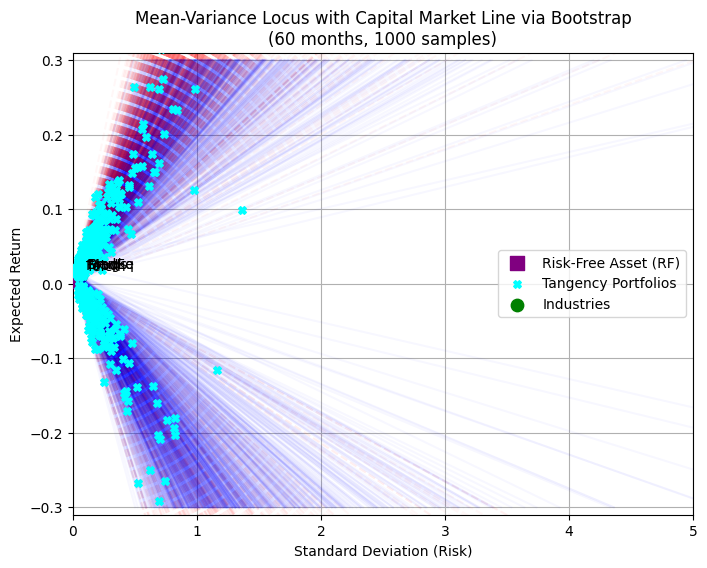

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 假设 df_filtered 已经存在，格式如下：
#     DATE     Food     Smoke    Drugs    MedEq    Telcm
# 0   192607   0.0012   0.0129   0.0091   0.0495   0.0083
# 1   192608   0.0268   0.0650   0.0426   0.0420   0.0217
# 2   192609   0.0158   0.0126  -0.0026   0.0402   0.0241
# ... 

# 定义无风险利率（每月0.4%）
rf = 0.004  

bootstrap_iterations = 1000   # 重复抽样次数
sample_size = 60              # 每个 bootstrap 样本的月份数

# 用于记录每次 bootstrap 下计算得到的切线组合参数（用于后续汇总或绘图）
tangency_returns_all = []
tangency_stds_all = []

# 建立绘图窗口
plt.figure(figsize=(8, 6))

# 重复 bootstrap 抽样
for i in range(bootstrap_iterations):
    # ------------------------------
    # 1. 从 df_filtered 中有放回抽取 60 个月的数据
    # ------------------------------
    sample = df_filtered.sample(n=sample_size, replace=True)
    # 去除 DATE 列，仅保留收益数据
    returns = sample.drop(columns='DATE')
    
    # ------------------------------
    # 2. 计算样本均值和协方差矩阵
    # ------------------------------
    mean_returns = returns.mean()           # Series，每个行业的平均收益
    cov_matrix = returns.cov()                # DataFrame，收益的协方差矩阵
    
    # 转换为 NumPy 数组，并构造单位向量
    mean_returns_vector = mean_returns.values
    ones_vector = np.ones(len(mean_returns))
    
    # ------------------------------
    # 3. 计算协方差矩阵的逆
    # ------------------------------
    try:
        inv_cov_matrix = np.linalg.inv(cov_matrix)
    except np.linalg.LinAlgError:
        # 若矩阵不可逆，则跳过该次抽样
        continue
    
    # ------------------------------
    # 4. 计算超额收益（均值减去无风险利率），并求切线组合（Tangency Portfolio）
    # ------------------------------
    excess_returns = mean_returns - rf
    # 计算分母 1' Σ⁻¹ (μ - rf) ；注意：excess_returns 需要转换为数组
    denom = ones_vector @ (inv_cov_matrix @ excess_returns.values)
    if denom == 0:
        continue
    tangency_weights = inv_cov_matrix @ excess_returns.values / denom
    tangency_return = np.dot(tangency_weights, mean_returns_vector)
    tangency_std = np.sqrt(tangency_weights.T @ cov_matrix.values @ tangency_weights)
    
    # 保存切线组合参数
    tangency_returns_all.append(tangency_return)
    tangency_stds_all.append(tangency_std)
    
    # ------------------------------
    # 5. 计算均值—方差前沿参数：A, B, C, Δ
    #     A = 1' Σ⁻¹ 1  
    #     B = 1' Σ⁻¹ μ  
    #     C = μ' Σ⁻¹ μ  
    #     Δ = A * C - B²
    # ------------------------------
    A = ones_vector @ (inv_cov_matrix @ ones_vector)
    B = ones_vector @ (inv_cov_matrix @ mean_returns_vector)
    C = mean_returns_vector @ (inv_cov_matrix @ mean_returns_vector)
    Delta = A * C - B**2
    if Delta <= 0:
        continue  # 参数不合法则跳过

    # ------------------------------
    # 6. 构造有效前沿
    #    定义一系列目标收益率（μ）的取值范围，这里取 -5% 到 6%
    # ------------------------------
    target_returns = np.linspace(-0.3, 0.3, 500)
    
    # 根据公式计算 λ 和 γ：
    #     λ = (C - μ B) / Δ  
    #     γ = (μ A - B) / Δ
    lambda_values = (C - target_returns * B) / Delta
    gamma_values = (target_returns * A - B) / Delta

    # 计算每个目标收益率对应的投资组合方差 σ²
    sigma_squared = []
    for lam, gam in zip(lambda_values, gamma_values):
        # 投资组合权重：w = λ Σ⁻¹ 1 + γ Σ⁻¹ μ
        w = lam * (inv_cov_matrix @ ones_vector) + gam * (inv_cov_matrix @ mean_returns_vector)
        sigma_sq = w.T @ cov_matrix.values @ w
        sigma_squared.append(sigma_sq)
    sigma_squared = np.array(sigma_squared)
    # 确保方差非负，然后取平方根得到标准差（风险）
    efficient_risks = np.sqrt(np.maximum(sigma_squared, 0))
    
    # ------------------------------
    # 7. 构造资本市场线（CML）
    #    根据切线组合的参数，资本市场线的公式为：  
    #         CML: E(R) = rf + ((tangency_return - rf) / tangency_std) * σ  
    # ------------------------------
    # 定义一组风险水平（σ）的取值，范围从 0 到 (max(efficient_risks)*1.5)
    cml_risks = np.linspace(0, max(efficient_risks) * 1.5, 300)
    cml_returns = rf + ((tangency_return - rf) / tangency_std) * cml_risks


    plt.plot(efficient_risks, target_returns, color='blue', alpha=0.03)
    plt.plot(cml_risks, cml_returns, linestyle='--', color='red', alpha=0.03)

# tangent line
plt.scatter(0, rf, color="purple", label="Risk-Free Asset (RF)", zorder=3, marker="s", s=100)
plt.scatter(tangency_stds_all, tangency_returns_all, color="cyan", label="Tangency Portfolios", zorder=3, marker="X", s=30)


full_returns = df_filtered.drop(columns='DATE')
full_mean_returns = full_returns.mean()
full_sd_returns = full_returns.std()
plt.scatter(full_sd_returns, full_mean_returns, marker='o', color='green', label="Industries", s=80)
for industry, x, y in zip(full_returns.columns, full_sd_returns, full_mean_returns):
    plt.annotate(industry, (x, y), fontsize=10, xytext=(5, 5), textcoords="offset points")

# plot
# ==============================================================================
plt.xlabel("Standard Deviation (Risk)")
plt.ylabel("Expected Return")
plt.title("Mean-Variance Locus with Capital Market Line via Bootstrap\n(60 months, 1000 samples)")
plt.xlim(0, 5)
plt.ylim(min(target_returns) - 0.01, max(target_returns) + 0.01)
plt.legend()
plt.grid(True)
plt.show()


In [23]:
import numpy as np
import pandas as pd

# 假设 df_filtered 已经存在，格式如下：
#      DATE     Food     Smoke    Drugs    MedEq    Telcm
# 0   192607   0.0012   0.0129   0.0091   0.0495   0.0083
# 1   192608   0.0268   0.0650   0.0426   0.0420   0.0217
# 2   192609   0.0158   0.0126  -0.0026   0.0402   0.0241
# ...
# 1181 rows × 6 columns

rf = 0.004  # 无风险利率（每月0.4%）

bootstrap_iterations = 1000  # 重复抽样次数
sample_size = 60             # 每个 bootstrap 样本取 60 个月数据

# 用于存储每次 bootstrap 得到的切线组合指标
tangency_returns = []    # 每次样本的切线组合预期收益
tangency_stds = []       # 每次样本的切线组合标准差
tangency_weights_list = []  # 每次样本的切线组合权重向量

for i in range(bootstrap_iterations):
    # -----------------------------
    # 1. 随机抽取 60 个月数据（有放回抽样）
    # -----------------------------
    sample = df_filtered.sample(n=sample_size, replace=True)
    # 去除 DATE 列，只保留收益数据
    returns = sample.drop(columns='DATE')
    
    # -----------------------------
    # 2. 计算样本均值和协方差矩阵
    # -----------------------------
    mean_returns = returns.mean()      # 各行业的平均收益（Series）
    cov_matrix = returns.cov()           # 收益的协方差矩阵（DataFrame）
    
    ones_vector = np.ones(len(mean_returns))  # 单位向量
    
    # 计算协方差矩阵的逆
    try:
        inv_cov_matrix = np.linalg.inv(cov_matrix)
    except np.linalg.LinAlgError:
        continue  # 如果协方差矩阵不可逆，则跳过此次抽样

    # -----------------------------
    # 3. 计算超额收益，并求切线组合（Tangency Portfolio）
    # -----------------------------
    excess_returns = mean_returns - rf   # 超额收益
    # 计算分母：1' Σ⁻¹ (μ - rf)，这里将 excess_returns 转换为数组
    denom = ones_vector @ (inv_cov_matrix @ excess_returns.values)
    if denom == 0:
        continue

    # 切线组合权重公式：w = Σ⁻¹ (μ - rf) / [1' Σ⁻¹ (μ - rf)]
    tangency_weights = inv_cov_matrix @ excess_returns.values / denom
    
    # 切线组合的预期收益和标准差
    tangency_return = np.dot(tangency_weights, mean_returns.values)
    tangency_std = np.sqrt(tangency_weights.T @ cov_matrix.values @ tangency_weights)
    
    # 存储本次 bootstrap 的结果
    tangency_returns.append(tangency_return)
    tangency_stds.append(tangency_std)
    tangency_weights_list.append(tangency_weights)

# 如果至少有一次有效的抽样结果，则汇总计算平均值
if len(tangency_returns) > 0:
    avg_tangency_return = np.mean(tangency_returns)
    avg_tangency_std = np.mean(tangency_stds)
    avg_tangency_variance = avg_tangency_std ** 2
    # 计算各行业权重的平均值（注意：tangency_weights_list 为 2D 数组，每行对应一个样本）
    avg_tangency_weights = np.mean(tangency_weights_list, axis=0)
else:
    raise ValueError("未能获得有效的 bootstrap 抽样结果，请检查数据。")

# -----------------------------
# 4. 将切线组合指标四舍五入到 6 位小数，并构造成 DataFrame
# -----------------------------
tangency_expected_return = round(avg_tangency_return, 6)  # 预期收益
tangency_variance = round(avg_tangency_variance, 6)         # 方差
tangency_std_rounded = round(avg_tangency_std, 6)             # 标准差

# DataFrame：切线组合特征信息
tangency_portfolio_info = pd.DataFrame({
    "Characteristic": ["Expected Return", "Variance", "Standard Deviation"],
    "Value": [tangency_expected_return, tangency_variance, tangency_std_rounded]
})

# DataFrame：切线组合各行业权重（DataFrame 的 index 与收益数据的列名称一致）
# 注意：这里使用 returns.columns，因为在循环内最后一次抽样时 returns 的列顺序即为各行业名称
tangency_weights_df = pd.DataFrame(avg_tangency_weights, index=returns.columns, columns=["Weight"])
tangency_weights_df = tangency_weights_df.round(6)

# -----------------------------
# 5. 输出结果
# -----------------------------
print("\nTangency Portfolio Characteristics for Specified Graph:")
print(tangency_portfolio_info.to_string(index=False))

print("\nTangency Portfolio Weights for Specified Graph:")
print(tangency_weights_df.to_string())



Tangency Portfolio Characteristics for Specified Graph:
    Characteristic    Value
   Expected Return 0.025102
          Variance 0.042120
Standard Deviation 0.205231

Tangency Portfolio Weights for Specified Graph:
         Weight
Food  -0.792428
Smoke  0.561995
Drugs  0.098282
MedEq  0.007779
Telcm  1.124372


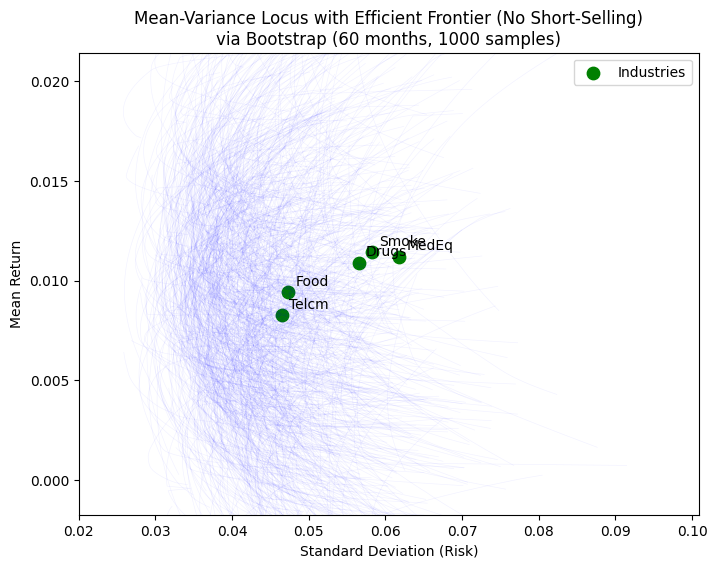

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# 设置 bootstrap 参数
bootstrap_iterations = 1000   # 重复 1000 次
sample_size = 60              # 每次抽取 60 个月数据

# 用于绘图时收集所有 bootstrap 样本的有效前沿数据（可选）
all_target_returns = []
all_efficient_risks = []

# 建立绘图窗口
plt.figure(figsize=(8, 6))

# ---------------------------
# 开始 bootstrap 循环
# ---------------------------
for i in range(bootstrap_iterations):
    # 1. 从 df_filtered 中随机抽取 60 个月数据（有放回抽样）
    sample = df_filtered.sample(n=sample_size, replace=True)
    # 去除 DATE 列，仅保留收益数据
    returns_sample = sample.drop(columns='DATE')
    
    # 2. 计算样本均值与协方差矩阵
    mean_returns = returns_sample.mean()       # Series，资产均值
    cov_matrix = returns_sample.cov()            # DataFrame，资产协方差矩阵
    
    # 定义资产数量
    num_assets = len(mean_returns)
    
    # 3. 计算最小方差组合（MVP），供后续确定有效前沿下界
    ones_vector = np.ones(num_assets)
    try:
        inv_cov_matrix = np.linalg.inv(cov_matrix)
    except np.linalg.LinAlgError:
        continue  # 若协方差矩阵不可逆，则跳过本次抽样
    
    mvp_weights = (inv_cov_matrix @ ones_vector) / (ones_vector.T @ inv_cov_matrix @ ones_vector)
    min_var_return = np.dot(mvp_weights, mean_returns)
    min_var_std = np.sqrt(mvp_weights.T @ cov_matrix.values @ mvp_weights)
    
    # 4. 设置无短售约束：所有权重必须介于 0 和 1 之间
    bounds = [(0, 1)] * num_assets
    
    # 5. 构造目标收益率序列
    #    这里以样本中最小均值到（样本中 "Smoke" 与 "Telcm" 均值中较大者 + 0.012857）的区间生成 200 个目标收益率
    target_returns_no_short = np.linspace(mean_returns.min(), 
                                          max(mean_returns["Smoke"], mean_returns["Telcm"]) + 0.012857, 
                                          200)
    
    efficient_risks_no_short = []  # 用于存储每个目标收益率对应的组合风险
    
    # 6. 对每个目标收益率求解最优组合（最小化组合波动率）
    for target in target_returns_no_short:
        # 定义约束条件：权重和为 1 以及组合均值等于 target
        constraints = (
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'eq', 'fun': lambda w, mr=mean_returns, t=target: np.dot(w, mr) - t}
        )
        
        # 初始猜测：等权重组合
        init_guess = np.ones(num_assets) / num_assets
        
        result = minimize(portfolio_volatility, init_guess, args=(cov_matrix.values,), 
                          method='SLSQP', constraints=constraints, bounds=bounds)
        
        # 如果求解成功，则记录该目标收益率对应的风险
        if result.success:
            efficient_risks_no_short.append(result.fun)
        else:
            efficient_risks_no_short.append(np.nan)
    
    # 将结果转换为 NumPy 数组，并剔除求解失败（NaN）的数据点
    efficient_risks_no_short = np.array(efficient_risks_no_short)
    valid = ~np.isnan(efficient_risks_no_short)
    target_returns_valid = target_returns_no_short[valid]
    efficient_risks_valid = efficient_risks_no_short[valid]
    
    # 7. 限制目标收益率不超过样本中 "Smoke" 与 "Telcm" 较大均值的上限
    max_return_limit = max(mean_returns["Smoke"], mean_returns["Telcm"])
    valid_indices = target_returns_valid <= max_return_limit
    target_returns_limited = target_returns_valid[valid_indices]
    efficient_risks_limited = efficient_risks_valid[valid_indices]
    
    # 可选：将本次 bootstrap 样本的结果保存起来（便于后续分析）
    all_target_returns.append(target_returns_limited)
    all_efficient_risks.append(efficient_risks_limited)
    
    # 8. 绘制本次 bootstrap 样本下的有效前沿（采用较细的蓝线和低透明度）
    plt.plot(efficient_risks_limited, target_returns_limited, color="blue", linewidth=0.5, alpha=0.05)

# ---------------------------
# 绘制全样本下各行业的点（使用 df_filtered 全体数据计算）
# ---------------------------
full_returns = df_filtered.drop(columns='DATE')
full_mean_returns = full_returns.mean()
full_std = full_returns.std()

plt.scatter(full_std, full_mean_returns, marker='o', color='green', label="Industries", s=80)
for industry, x, y in zip(full_mean_returns.index, full_std, full_mean_returns):
    plt.annotate(industry, (x, y), fontsize=10, xytext=(5, 5), textcoords="offset points")

# ---------------------------
# 图形格式调整
# ---------------------------
plt.xlabel("Standard Deviation (Risk)")
plt.ylabel("Mean Return")
plt.title("Mean-Variance Locus with Efficient Frontier (No Short-Selling)\nvia Bootstrap (60 months, 1000 samples)")

# 这里根据实际数据调整 x 轴和 y 轴的范围
plt.xlim(0.02, None)
# y 轴范围可以根据全样本数据进行设置（此处仅作示例）
plt.ylim(full_mean_returns.min() - 0.01, full_mean_returns.max() + 0.01)

plt.legend()
plt.grid(False)
plt.show()


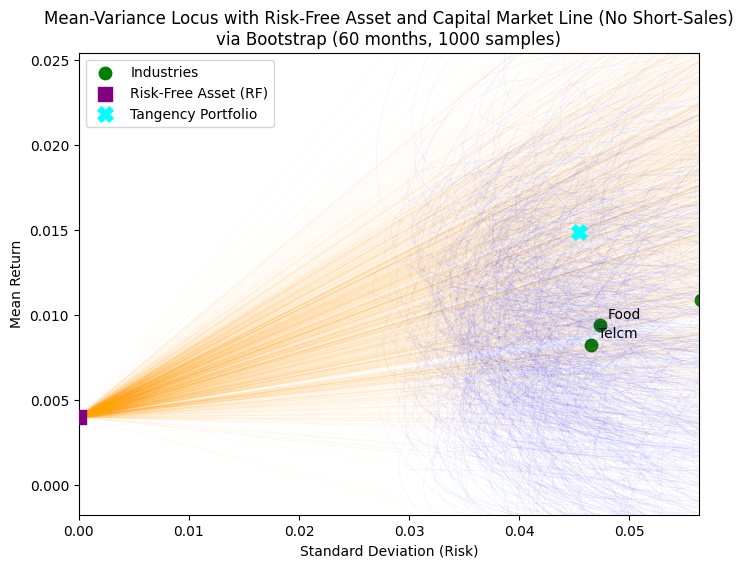

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize


# ---------------------------
rf = 0.004  # 无风险利率（绝对值，0.4% per month）
bootstrap_iterations = 1000  # 重复抽样次数
sample_size = 60             # 每个 bootstrap 样本取 60 个月数据

# 定义计算组合波动率的函数
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# 为后续绘图创建画布
plt.figure(figsize=(8, 6))

# ---------------------------
# 开始 bootstrap 循环
# ---------------------------
for i in range(bootstrap_iterations):
    # 1. 随机抽取 60 个月数据（有放回抽样）
    sample = df_filtered.sample(n=sample_size, replace=True)
    # 去除 DATE 列，只保留收益数据
    returns_sample = sample.drop(columns='DATE')
    
    # 2. 计算样本均值和协方差矩阵
    mean_returns = returns_sample.mean()       # Series，资产均值（绝对收益形式）
    cov_matrix = returns_sample.cov()            # DataFrame，资产协方差矩阵
    num_assets = len(mean_returns)
    
    # 设置初始猜测和无短售约束
    init_guess = np.ones(num_assets) / num_assets
    bounds = [(0, 1)] * num_assets
    
    # 3. 调整均值为超额收益形式（减去 rf）
    mean_returns_excess = mean_returns - rf
    
    # 4. 构造无短售约束下的有效前沿（在超额收益空间）
    #    这里生成 200 个目标超额收益率，从样本最小超额收益到样本最大超额收益加一个常数
    target_returns_no_short_rf = np.linspace(mean_returns_excess.min(), 
                                              mean_returns_excess.max() + 0.012857, 
                                              200)
    efficient_risks_no_short_rf = []
    
    # 对每个目标超额收益率求解最优组合（最小化组合波动率）
    for target in target_returns_no_short_rf:
        constraints = [
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'eq', 'fun': lambda w: np.dot(w, mean_returns_excess) - target}
        ]
        result = minimize(lambda w: portfolio_volatility(w, cov_matrix.values),
                          init_guess, method='SLSQP',
                          constraints=constraints, bounds=bounds)
        if result.success:
            efficient_risks_no_short_rf.append(result.fun)
        else:
            efficient_risks_no_short_rf.append(np.nan)
    
    # 将列表转换为 numpy 数组，并去除求解失败的点（NaN）
    efficient_risks_no_short_rf = np.array(efficient_risks_no_short_rf)
    target_returns_no_short_rf = np.array(target_returns_no_short_rf)
    valid_indices_rf = ~np.isnan(efficient_risks_no_short_rf)
    efficient_risks_no_short_rf = efficient_risks_no_short_rf[valid_indices_rf]
    target_returns_no_short_rf = target_returns_no_short_rf[valid_indices_rf]
    
    # 5. 限制目标超额收益率的上限
    #    这里以样本中 "Smoke" 与 "Telcm" 的超额收益中较大者为上限
    max_return_limit_rf = max(mean_returns_excess["Smoke"], mean_returns_excess["Telcm"])
    valid_indices_rf = target_returns_no_short_rf <= max_return_limit_rf
    efficient_risks_no_short_limited_rf = efficient_risks_no_short_rf[valid_indices_rf]
    target_returns_no_short_limited_rf = target_returns_no_short_rf[valid_indices_rf]
    
    # 6. 计算该 bootstrap 样本下的切线组合
    #    利用 Sharpe Ratio 最大化（即最小化负 Sharpe Ratio）
    def objective_sharpe(w, mean_returns, cov_matrix, rf):
        port_return = np.dot(w, mean_returns)  # 组合预期收益（绝对收益）
        port_vol = portfolio_volatility(w, cov_matrix.values)
        sharpe_ratio = (port_return - rf) / port_vol
        return -sharpe_ratio  # 最小化负的 Sharpe Ratio，即最大化 Sharpe Ratio
    
    constraints_tangency = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    result_tangency = minimize(objective_sharpe, init_guess,
                               args=(mean_returns, cov_matrix, rf),
                               bounds=bounds, constraints=constraints_tangency)
    if result_tangency.success:
        optimal_weights = result_tangency.x
        tangency_return = np.dot(optimal_weights, mean_returns)  # 绝对收益
        tangency_std = portfolio_volatility(optimal_weights, cov_matrix.values)
    else:
        # 若未能求解成功，则跳过此样本
        continue
    
    # 7. 构造扩展的资本市场线 (CML)
    #    在横轴风险范围内，计算对应的收益： CML: R = rf + ((R_tan - rf) / sigma_tan) * sigma
    #    这里设定横轴风险范围为 0 到 (1.5×样本中最高风险)
    cml_risk = np.linspace(0, max(efficient_risks_no_short_limited_rf) * 1.5, 300)
    cml_return = rf + ((tangency_return - rf) / tangency_std) * cml_risk
    
    # 8. 绘制本次 bootstrap 样本下的结果
    #    注意：由于目标收益均为超额收益，此处绘制时加上 rf 还原为绝对收益
    plt.plot(efficient_risks_no_short_limited_rf, target_returns_no_short_limited_rf + rf, 
             color="blue", linewidth=0.5, alpha=0.05)  # 有效前沿
    plt.plot(cml_risk, cml_return, color="orange", linewidth=0.5, alpha=0.05)  # CML

# ---------------------------
# 绘制全样本各行业数据点（使用 df_filtered 全体数据计算）
# ---------------------------
full_returns = df_filtered.drop(columns='DATE')
full_mean_returns = full_returns.mean()
full_std = full_returns.std()

plt.scatter(full_std, full_mean_returns, marker='o', color='green', label="Industries", s=80)
for industry, x, y in zip(full_mean_returns.index, full_std, full_mean_returns):
    plt.annotate(industry, (x, y), fontsize=10, xytext=(5,5), textcoords="offset points")

# 绘制无风险资产点（风险为 0，收益为 rf）
plt.scatter(0, rf, color="purple", label="Risk-Free Asset (RF)", zorder=3, marker="s", s=100)
# 绘制切线组合点
plt.scatter(tangency_std, tangency_return, color="cyan", label="Tangency Portfolio", zorder=3, marker="X", s=120)

# ---------------------------
# 图形格式调整
# ---------------------------
plt.xlabel("Standard Deviation (Risk)")
plt.ylabel("Mean Return")
plt.title("Mean-Variance Locus with Risk-Free Asset and Capital Market Line (No Short-Sales)\nvia Bootstrap (60 months, 1000 samples)")
plt.xlim(0, max(efficient_risks_no_short_limited_rf) * 1.2)
# 根据全样本数据调整 Y 轴范围（加上 rf 后为绝对收益）
plt.ylim(full_mean_returns.min() - 0.01, full_mean_returns.max() + rf + 0.01)
plt.legend()
plt.grid(False)

# 显示最终图形
plt.show()


In [26]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# 假设 df_filtered 已经存在，格式如下：
#      DATE     Food     Smoke    Drugs    MedEq    Telcm
# 0   192607   0.0012   0.0129   0.0091   0.0495   0.0083
# 1   192608   0.0268   0.0650   0.0426   0.0420   0.0217
# 2   192609   0.0158   0.0126  -0.0026   0.0402   0.0241
# ...
# 1182 rows × 6 columns

# ---------------------------
# 参数设置
# ---------------------------
rf = 0.004               # 无风险利率，每月 0.4%
sample_size = 60         # 每个 bootstrap 样本 60 个月数据
bootstrap_iterations = 1000  # 重复抽样次数

# ---------------------------
# 定义计算组合波动率的函数
# ---------------------------
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# ---------------------------
# 定义目标函数：负的 Sharpe Ratio（用于求解切线组合）
# ---------------------------
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, rf):
    port_return = np.dot(weights, mean_returns)
    port_vol = portfolio_volatility(weights, cov_matrix)
    sharpe_ratio = (port_return - rf) / port_vol
    return -sharpe_ratio  # 我们要最大化 Sharpe Ratio，即最小化负的 Sharpe Ratio

# 用于保存 1000 次抽样下的切线组合参数
tangency_returns = []      # 每次抽样的切线组合预期收益（绝对收益）
tangency_stds = []         # 每次抽样的切线组合标准差
optimal_weights_list = []  # 每次抽样的切线组合最优权重（数组）

# ---------------------------
# Bootstrap 循环
# ---------------------------
for i in range(bootstrap_iterations):
    # 从 df_filtered 中随机抽取 60 个月数据（有放回抽样）
    bootstrap_sample = df_filtered.sample(n=sample_size, replace=True)
    # 去除 DATE 列，保留各资产收益数据
    returns = bootstrap_sample.drop(columns='DATE')
    
    # 计算该样本的均值和协方差矩阵
    mean_returns = returns.mean()         # Series
    cov_matrix = returns.cov()              # DataFrame
    num_assets = len(mean_returns)
    
    # 初始猜测：等权重
    init_guess = np.ones(num_assets) / num_assets
    # 约束条件：权重和为 1
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    # 这里不设边界（允许空头），若需要可添加 bounds = [(0,1)]*num_assets
    
    # 求解切线组合（最大化 Sharpe Ratio，即最小化负 Sharpe Ratio）
    result = minimize(negative_sharpe_ratio, init_guess,
                      args=(mean_returns.values, cov_matrix.values, rf),
                      constraints=constraints, method='SLSQP')
    
    # 如果优化成功，则保存结果
    if result.success:
        optimal_weights = result.x
        tangency_return = np.dot(optimal_weights, mean_returns.values)
        tangency_std = portfolio_volatility(optimal_weights, cov_matrix.values)
        
        tangency_returns.append(tangency_return)
        tangency_stds.append(tangency_std)
        optimal_weights_list.append(optimal_weights)

# 如果至少有一次有效结果，则计算平均值
if len(tangency_returns) == 0:
    raise ValueError("没有成功的优化结果，请检查数据或优化设置。")

avg_tangency_return = np.mean(tangency_returns)
avg_tangency_std = np.mean(tangency_stds)
avg_optimal_weights = np.mean(optimal_weights_list, axis=0)

# ---------------------------
# 将切线组合特征保留 6 位小数
# ---------------------------
tangency_expected_return = round(avg_tangency_return, 6)  # 预期收益
tangency_variance = round(avg_tangency_std ** 2, 6)         # 方差 = (标准差)^2
tangency_std_rounded = round(avg_tangency_std, 6)           # 标准差

# 创建显示切线组合特征的 DataFrame
tangency_portfolio_info = pd.DataFrame({
    "Characteristic": ["Expected Return", "Variance", "Standard Deviation"],
    "Value": [tangency_expected_return, tangency_variance, tangency_std_rounded]
})

# 创建显示切线组合权重的 DataFrame
# 使用最后一次循环中计算得到的 mean_returns 的 index（各资产名称）
tangency_weights_df = pd.DataFrame(avg_optimal_weights, index=mean_returns.index, columns=["Weight"])
tangency_weights_df = tangency_weights_df.round(6)

# ---------------------------
# 输出结果
# ---------------------------
print("\nTangency Portfolio Characteristics:")
print(tangency_portfolio_info.to_string(index=False))

print("\nTangency Portfolio Weights:")
print(tangency_weights_df.to_string())



Tangency Portfolio Characteristics:
    Characteristic       Value
   Expected Return   17.748487
          Variance 5932.453171
Standard Deviation   77.022420

Tangency Portfolio Weights:
           Weight
Food  -246.165066
Smoke  342.015970
Drugs  281.690617
MedEq  139.065933
Telcm -515.607454
